In [34]:
# init settings

import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

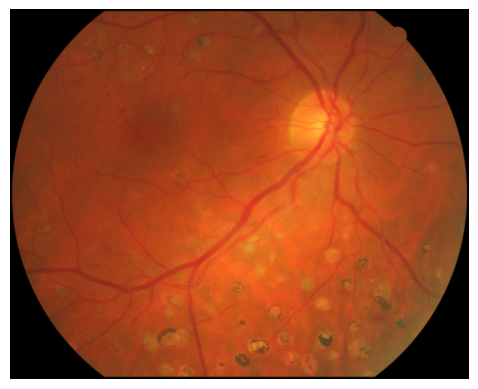

In [35]:
# 이미지 확인

image_path = '/kaggle/input/glaucoma-datasets/G1020/Images/image_0.jpg'

img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [36]:
# 1. data load and preprocessing

# 이미지 전처리 함수
def load_and_preprocess_image(filepath):
    img = cv2.imread(filepath)
    img = cv2.resize(img, (128, 128))  # 크기 조정
    img = img / 255.0  # 정규화
    return img

# CSV 파일 불러오기
csv_path = "/kaggle/input/glaucoma-datasets/G1020/G1020.csv"
labels_df = pd.read_csv(csv_path)

# 이미지 ID와 라벨을 매칭하는 딕셔너리 생성
labels_dict = dict(zip(labels_df['imageID'], labels_df['binaryLabels']))
print("라벨 예시:", list(labels_dict.items())[:5])

# 이미지 불러오기 및 전처리 함수
def load_dataset_with_labels(directory, labels_dict):
    images = []
    labels = []
    
    for img_file in os.listdir(directory):
        if img_file in labels_dict:  # CSV에 언급된 이미지 파일만 불러오기
            img_path = os.path.join(directory, img_file)
            img = load_and_preprocess_image(img_path)  # 이미지 전처리
            images.append(img)
            labels.append(labels_dict[img_file])  # 라벨 추가
            
    return np.array(images), np.array(labels)

# 데이터 로드
image_directory = "/kaggle/input/glaucoma-datasets/G1020/Images"
images, labels = load_dataset_with_labels(image_directory, labels_dict)
print("로드된 이미지 수:", images.shape[0])
print("로드된 라벨 수:", labels.shape[0])

라벨 예시: [('image_0.jpg', 0), ('image_1.jpg', 0), ('image_3.jpg', 0), ('image_4.jpg', 0), ('image_5.jpg', 0)]
로드된 이미지 수: 1020
로드된 라벨 수: 1020


In [37]:
# 데이터셋을 섞어 훈련 및 검증 세트로 나누기
def split_dataset(images, labels, train_ratio=0.8):
    # 데이터셋 섞기
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    
    # 지정된 비율로 나누기
    train_size = int(len(images) * train_ratio)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
    
    # 훈련 및 검증 세트 생성
    train_images, val_images = images[train_indices], images[val_indices]
    train_labels, val_labels = labels[train_indices], labels[val_indices]
    
    return train_images, train_labels, val_images, val_labels

# 훈련 및 검증 데이터 나누기
train_images, train_labels, val_images, val_labels = split_dataset(images, labels, train_ratio=0.8)

print(f"훈련 이미지 수: {train_images.shape[0]}")
print(f"검증 이미지 수: {val_images.shape[0]}")

훈련 이미지 수: 816
검증 이미지 수: 204


In [38]:
# 미니 배치 데이터 로더

def data_loader(images, labels, batch_size=32):
    indices = np.arange(len(images))
    np.random.shuffle(indices)  # 데이터 섞기
    for start_idx in range(0, len(images), batch_size):
        batch_indices = indices[start_idx:start_idx + batch_size]
        yield images[batch_indices], labels[batch_indices]
        
train_loader = data_loader(train_images, train_labels, batch_size=32)
val_loader = data_loader(val_images, val_labels, batch_size=32)